### Download Data

The data is taken from http://archive.ics.uci.edu/ml/machine-learning-databases/00240/, but you can have it in the form of the UCI-HAR-Dataset.zip.

Extract it to the folder of your notebook with the solution (or suitably adjust the paths to training and test data specified below (TRAIN, TEST).  

Spcifically, the split into training and testing data is already done. The dataset contains 7352 training and 2947 test samples.  

Each sample consists of nine timeseries of float values, each of length 128.

The nine timeseries are collected by an accelerometer and a gyroscope that contain information about the motion and the orientation, respectively.

In [1]:
import os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

### Load Data

In [2]:
# Useful Constants
TRAIN = "UCI_HAR_Dataset/train/"
TEST = "UCI_HAR_Dataset/test/"

# x-values, 'signals'
# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]
X_train_signals_paths = [TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES]
X_test_signals_paths =  [TEST  + "Inertial Signals/" + signal + "test.txt"  for signal in INPUT_SIGNAL_TYPES]


# y-values, 'labels'
#Output classes to learn how to classify
LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]
N_CLASSES = len(LABELS)
y_train_path = TRAIN + "y_train.txt"
y_test_path  = TEST  + "y_test.txt"

In [3]:
# Load "X" (the neural network's training and testing inputs)
def load_X(X_signals_paths):
    X_signals = []
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)
print(X_train.shape, X_test.shape)

(7352, 128, 9) (2947, 128, 9)


In [4]:
# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return y_ - 1

def one_hot(y, n_classes):
    y = y.reshape(len(y))
    return np.eye(n_classes)[np.array(y, dtype=np.int32)]

def label_from_onehot(vectors):
    indices = []
    for vector in vectors:
        indices.append(np.argmax(vector))
    return np.array(indices)

Y_train = one_hot(load_y(y_train_path), N_CLASSES)
Y_test = one_hot(load_y(y_test_path), N_CLASSES)
print(Y_train.shape, Y_test.shape)

(7352, 6) (2947, 6)


#### Plot some samples

In [5]:
X_train_per_class = {}
for c in range(N_CLASSES):
    mask = label_from_onehot(Y_train)==c
    X_train_per_class[c] = X_train[mask]

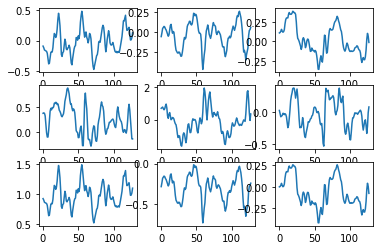

In [6]:
def plot_lines(X, nsamples):
    t = range(128)
    for i in range(9):
        plt.subplot(3,3,i+1)
        for j in range(np.minimum(X.shape[0],nsamples)):
            plt.plot(t,X[j,:,i])
    plt.show()
    
plot_lines(X_train_per_class[1], 1)

In [7]:
# Input Data
training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
means = np.mean(X_train, axis=(0,1))
stdevs = np.std(X_train, axis=(0,1))

print("X shape, Y_shape:")
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print()
print("Mean / Stdev for each feature:")
for i in range(9):
    print("%7.4f | %7.4f"%(means[i], stdevs[i]))

X shape, Y_shape:
(7352, 128, 9) (7352, 6)
(2947, 128, 9) (2947, 6)

Mean / Stdev for each feature:
-0.0006 |  0.1948
-0.0003 |  0.1224
-0.0003 |  0.1069
 0.0005 |  0.4068
-0.0008 |  0.3819
 0.0001 |  0.2557
 0.8047 |  0.4141
 0.0288 |  0.3910
 0.0865 |  0.3578


### Normalization

Can be skipped since the features are all at similar scales aready.

### Utilities

In [8]:
def performance_plots(model, X_test, Y_test, log, epochs):    
    acc = log.history['accuracy']
    val_acc = log.history['val_accuracy']
    print('Train accuracy (end):', acc[-1])
    print('Train accuracy (max):', np.max(acc))
    print('Test accuracy (end) :', val_acc[-1])
    print('Test accuracy (max) :', np.max(val_acc))

    plt.plot(log.history['accuracy'])
    plt.plot(log.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.axis([0,epochs,0.0,1.0])
    plt.show()

    plt.plot(log.history['loss'])
    plt.plot(log.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.axis([0,epochs,0.0,2.0])
    plt.show()

In [9]:
import sklearn
from sklearn import metrics
import pandas as pd
activities = ["walk", "up", "down", "sit", "stand", "lay"]

def confusion_matrix(model, X_test, Y_test):
    scores = model.predict(X_test)
    predictions = np.argmax(scores, axis=1)
    labels = np.argmax(Y_test, axis=1)
    cm = sklearn.metrics.confusion_matrix(labels, predictions)
    df = pd.DataFrame({activities[i] : cm[:,i] for i in range(len(activities))}, activities)
    return df

## Specify and Train Models

Try different architectures to solve the activity recognition problem.

At minimum implement
* Model with a single layer of SimpleRNN
* Model with several layers of SimpleRNNs
* Model with several CNN layers
* Mixed model with several layers of CNNs, then its output model with 1+ layers of SimpleRNNs

Try with different number of units.

Report about your findings.

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import SimpleRNN, Conv2D

### Single Layer SimpleRNN

In [11]:
### START YOUR CODE

model = Sequential()
model.add(Input((128, 9)))
model.add(SimpleRNN(100, return_sequences=False, activation='tanh', kernel_initializer='glorot_uniform'))
model.add(Dense(N_CLASSES, activation='softmax'))

opt = Adam(learning_rate=0.001)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

### END YOUR CODE

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 100)               11000     
_________________________________________________________________
dense (Dense)                (None, 6)                 606       
Total params: 11,606
Trainable params: 11,606
Non-trainable params: 0
_________________________________________________________________


In [12]:
### START YOUR CODE
batch_size = 32
n_epochs   = 30

log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

Epoch 1/30
230/230 [==============================] - 5s 18ms/step - loss: 1.3553 - accuracy: 0.4311 - val_loss: 1.3794 - val_accuracy: 0.4411
Epoch 2/30
230/230 [==============================] - 4s 17ms/step - loss: 1.2036 - accuracy: 0.5041 - val_loss: 1.1836 - val_accuracy: 0.5087
Epoch 3/30
230/230 [==============================] - 4s 17ms/step - loss: 0.9393 - accuracy: 0.6084 - val_loss: 0.8547 - val_accuracy: 0.6362
Epoch 4/30
230/230 [==============================] - 4s 16ms/step - loss: 0.8496 - accuracy: 0.6460 - val_loss: 1.3454 - val_accuracy: 0.4316
Epoch 5/30
230/230 [==============================] - 4s 17ms/step - loss: 1.2630 - accuracy: 0.4683 - val_loss: 1.1077 - val_accuracy: 0.5358
Epoch 6/30
230/230 [==============================] - 4s 16ms/step - loss: 1.0618 - accuracy: 0.5655 - val_loss: 1.2285 - val_accuracy: 0.5355
Epoch 7/30
230/230 [==============================] - 4s 16ms/step - loss: 1.0676 - accuracy: 0.5634 - val_loss: 1.0815 - val_accuracy: 0.5758

Train accuracy (end): 0.6644450426101685
Train accuracy (max): 0.6875680088996887
Test accuracy (end) : 0.6467593908309937
Test accuracy (max) : 0.6549032926559448


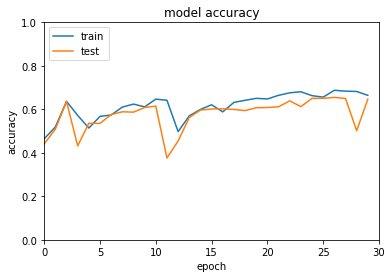

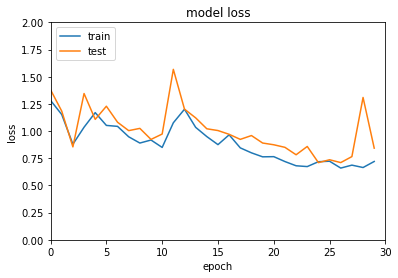

,walk,up,down,sit,stand,lay
walk,164,168,156,1,7,0
up,128,239,79,6,14,5
down,129,108,181,0,2,0
sit,1,2,0,361,127,0
stand,0,4,0,74,454,0
lay,0,4,0,3,23,507


In [13]:
performance_plots(model, X_test, Y_test, log, n_epochs)
confusion_matrix(model, X_test, Y_test)

#### Findings

...

### Stacked Simple RNNs

In [14]:
### START YOUR CODE

model = Sequential()
model.add(Input((128, 9)))
model.add(SimpleRNN(100, return_sequences=True, activation='tanh', kernel_initializer='glorot_uniform'))
model.add(SimpleRNN(100, return_sequences=True, activation='tanh', kernel_initializer='glorot_uniform'))
model.add(SimpleRNN(100, return_sequences=False, activation='tanh', kernel_initializer='glorot_uniform'))
model.add(Dense(N_CLASSES, activation='softmax'))

opt = Adam(learning_rate=0.001)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

### END YOUR CODE

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 128, 100)          11000     
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 128, 100)          20100     
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 100)               20100     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 606       
Total params: 51,806
Trainable params: 51,806
Non-trainable params: 0
_________________________________________________________________


In [15]:
### START YOUR CODE
batch_size = 32
n_epochs   = 20

log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

Epoch 1/20
230/230 [==============================] - 13s 51ms/step - loss: 0.9422 - accuracy: 0.5993 - val_loss: 0.6820 - val_accuracy: 0.7679
Epoch 2/20
230/230 [==============================] - 12s 50ms/step - loss: 0.5630 - accuracy: 0.7813 - val_loss: 0.9442 - val_accuracy: 0.6098
Epoch 3/20
230/230 [==============================] - 12s 50ms/step - loss: 0.6569 - accuracy: 0.7225 - val_loss: 0.8576 - val_accuracy: 0.7024
Epoch 4/20
230/230 [==============================] - 12s 51ms/step - loss: 0.4343 - accuracy: 0.8391 - val_loss: 0.7085 - val_accuracy: 0.7754
Epoch 5/20
230/230 [==============================] - 12s 51ms/step - loss: 0.3718 - accuracy: 0.8735 - val_loss: 0.7387 - val_accuracy: 0.7119
Epoch 6/20
230/230 [==============================] - 12s 51ms/step - loss: 0.4826 - accuracy: 0.8208 - val_loss: 0.8214 - val_accuracy: 0.6169
Epoch 7/20
230/230 [==============================] - 12s 51ms/step - loss: 0.6874 - accuracy: 0.6780 - val_loss: 2.0354 - val_accuracy:

Train accuracy (end): 0.6230957508087158
Train accuracy (max): 0.8560935854911804
Test accuracy (end) : 0.5812690854072571
Test accuracy (max) : 0.7753647565841675


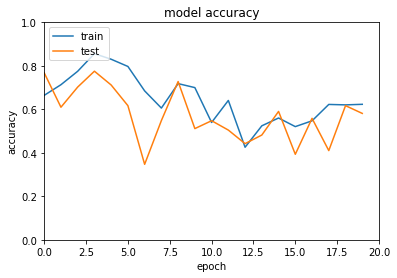

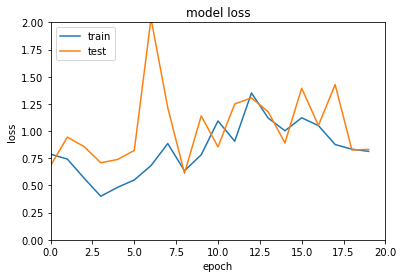

,walk,up,down,sit,stand,lay
walk,171,111,121,0,76,17
up,170,171,84,4,36,6
down,159,146,110,0,5,0
sit,0,0,1,208,277,5
stand,0,1,4,10,516,1
lay,0,0,0,0,0,537


In [16]:
performance_plots(model, X_test, Y_test, log, n_epochs)
confusion_matrix(model, X_test, Y_test)

#### Findings

...

### Several CNN Layers

In [18]:
### START YOUR CODE
dropout_rate = 0.2

model = Sequential()
model.add(Input((128, 9, 1)))

model.add(Conv2D(filters=16, kernel_size=(5,1), strides=(2,1), activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(dropout_rate))

model.add(Conv2D(filters=32, kernel_size=(3,1), strides=(2,1), activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(dropout_rate))

model.add(Conv2D(filters=64, kernel_size=(3,1), strides=(2,1), activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(dropout_rate))

model.add(Conv2D(filters=64, kernel_size=(3,1), strides=(2,1), activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(dropout_rate))

model.add(Flatten())
model.add(Dense(N_CLASSES, activation='softmax'))

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

### END YOUR CODE

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 9, 16)         96        
_________________________________________________________________
dropout (Dropout)            (None, 62, 9, 16)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 9, 32)         1568      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 9, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 9, 64)         6208      
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 9, 64)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 9, 64)         

In [19]:
### START YOUR CODE
batch_size = 32
n_epochs   = 30

X_train_expanded = np.expand_dims(X_train, axis=-1)
X_test_expanded = np.expand_dims(X_test, axis=-1)

log = model.fit(X_train_expanded, Y_train, 
                batch_size=batch_size, 
                epochs=n_epochs, 
                validation_data=(X_test_expanded, Y_test))

Epoch 1/30
230/230 [==============================] - 3s 13ms/step - loss: 0.5848 - accuracy: 0.7580 - val_loss: 0.3653 - val_accuracy: 0.8761
Epoch 2/30
230/230 [==============================] - 3s 13ms/step - loss: 0.2444 - accuracy: 0.9057 - val_loss: 0.3370 - val_accuracy: 0.8843
Epoch 3/30
230/230 [==============================] - 3s 13ms/step - loss: 0.1762 - accuracy: 0.9324 - val_loss: 0.2204 - val_accuracy: 0.9165
Epoch 4/30
230/230 [==============================] - 3s 13ms/step - loss: 0.1658 - accuracy: 0.9362 - val_loss: 0.2152 - val_accuracy: 0.9131
Epoch 5/30
230/230 [==============================] - 3s 13ms/step - loss: 0.1352 - accuracy: 0.9451 - val_loss: 0.1910 - val_accuracy: 0.9277
Epoch 6/30
230/230 [==============================] - 3s 13ms/step - loss: 0.1220 - accuracy: 0.9513 - val_loss: 0.1977 - val_accuracy: 0.9247
Epoch 7/30
230/230 [==============================] - 3s 13ms/step - loss: 0.1108 - accuracy: 0.9558 - val_loss: 0.2320 - val_accuracy: 0.9114

Train accuracy (end): 0.9787812829017639
Train accuracy (max): 0.9787812829017639
Test accuracy (end) : 0.9331523776054382
Test accuracy (max) : 0.9457074999809265


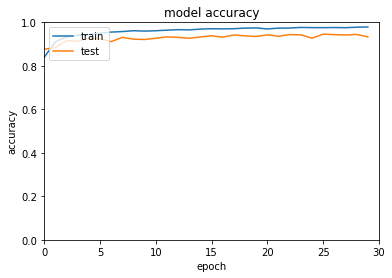

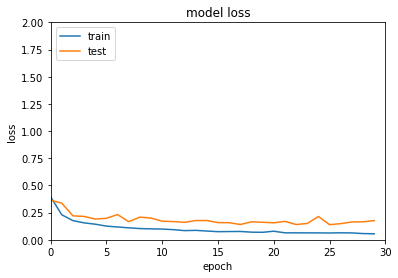

,walk,up,down,sit,stand,lay
walk,493,3,0,0,0,0
up,5,466,0,0,0,0
down,4,20,396,0,0,0
sit,0,2,0,411,78,0
stand,0,2,0,65,465,0
lay,0,18,0,0,0,519


In [20]:
performance_plots(model, X_test, Y_test, log, n_epochs)
confusion_matrix(model, X_test_expanded, Y_test)

#### Findings

...

### Mixed CNN and RNN

In [21]:
### START YOUR CODE

model = Sequential()
model.add(Input((128, 9, 1)))
model.add(Conv2D(16, kernel_size=(5,1), strides=(2,1), activation='relu', kernel_initializer='he_normal'))
model.add(Conv2D(32, kernel_size=(3,1), strides=(2,1), activation='relu', kernel_initializer='he_normal'))
model.add(Reshape((30,9*32)))
model.add(SimpleRNN(100, return_sequences=False, activation='tanh', kernel_initializer='glorot_uniform'))
model.add(Dense(N_CLASSES, activation='softmax'))

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
### END YOUR CODE

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 9, 16)         96        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 9, 32)         1568      
_________________________________________________________________
reshape (Reshape)            (None, 30, 288)           0         
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 100)               38900     
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 606       
Total params: 41,170
Trainable params: 41,170
Non-trainable params: 0
_________________________________________________________________


In [22]:
### START YOUR CODE
batch_size = 32
n_epochs   = 30

X_train_expanded = np.expand_dims(X_train, axis=-1)
X_test_expanded = np.expand_dims(X_test, axis=-1)

log = model.fit(X_train_expanded, Y_train, 
                batch_size=batch_size, 
                epochs=n_epochs, 
                validation_data=(X_test_expanded, Y_test))

Epoch 1/30
230/230 [==============================] - 3s 11ms/step - loss: 0.6290 - accuracy: 0.7219 - val_loss: 0.4864 - val_accuracy: 0.8212
Epoch 2/30
230/230 [==============================] - 2s 10ms/step - loss: 0.2922 - accuracy: 0.8921 - val_loss: 0.5217 - val_accuracy: 0.8195
Epoch 3/30
230/230 [==============================] - 2s 10ms/step - loss: 0.2068 - accuracy: 0.9215 - val_loss: 0.4066 - val_accuracy: 0.8487
Epoch 4/30
230/230 [==============================] - 2s 10ms/step - loss: 0.1799 - accuracy: 0.9353 - val_loss: 0.3528 - val_accuracy: 0.8935
Epoch 5/30
230/230 [==============================] - 2s 10ms/step - loss: 0.2646 - accuracy: 0.9094 - val_loss: 0.2776 - val_accuracy: 0.9019
Epoch 6/30
230/230 [==============================] - 2s 10ms/step - loss: 0.1248 - accuracy: 0.9492 - val_loss: 0.3219 - val_accuracy: 0.9046
Epoch 7/30
230/230 [==============================] - 2s 10ms/step - loss: 0.1144 - accuracy: 0.9532 - val_loss: 0.3127 - val_accuracy: 0.8941

Train accuracy (end): 0.9624592065811157
Train accuracy (max): 0.9706202149391174
Test accuracy (end) : 0.8975229263305664
Test accuracy (max) : 0.9250084757804871


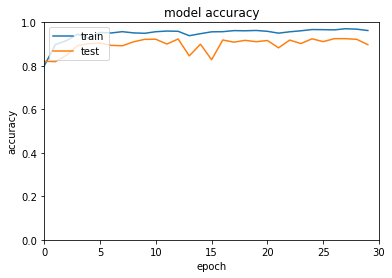

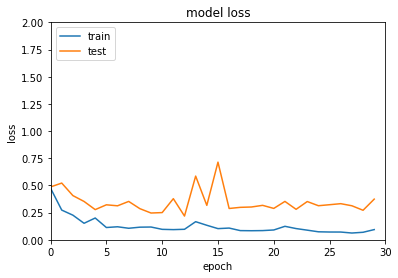

,walk,up,down,sit,stand,lay
walk,487,1,8,0,0,0
up,84,358,27,1,1,0
down,3,0,417,0,0,0
sit,0,8,3,382,98,0
stand,0,0,0,68,464,0
lay,0,0,0,0,0,537


In [23]:
performance_plots(model, X_test, Y_test, log, n_epochs)
confusion_matrix(model, X_test_expanded, Y_test)

#### Findings

...